# Single Subject Segmentation Q1K

In [1]:
# #use these commented parameters for testing this notebook outside of the automated loop of q1k_automated_reports.ipynb
# subject_id = "0042P"
# task_id = "VS"
# session_id = "01"
# run_id = "1"

#use these parameters when executing this notebook from the automation notebook..
subject_id = ""
task_id = ""
session_id = ""
run_id = ""


In [2]:
# import packages
import mne
import mne_bids
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from pathlib import Path
import shutil
import pylossless as ll
from autoreject import AutoReject

import warnings
warnings.filterwarnings('ignore')


# Set the parameters and read the pylossless data.

In [3]:
project_path = "/project/def-emayada/q1k/experimental/"
pylossless_path = "derivatives/pylossless/"
sync_loss_path = "derivatives/sync_loss/"
segment_path = "derivatives/segment/"

bids_path = mne_bids.BIDSPath(
    subject=subject_id, session=session_id, task=task_id, run="1", datatype="eeg", suffix="eeg",root=project_path + pylossless_path + sync_loss_path
)
print(bids_path)

/project/def-emayada/q1k/experimental/derivatives/pylossless/derivatives/sync_loss/sub-0042P/ses-01/eeg/sub-0042P_ses-01_task-VS_run-1_eeg.edf


In [4]:
# Read the BIDS pylossless output file..
eeg_raw = mne_bids.read_raw_bids(bids_path=bids_path, verbose=False)

In [5]:
#show channel types...
channel_types = eeg_raw.get_channel_types()
print("Channel Types:", channel_types)
print("Channel Names:", eeg_raw.info['ch_names'])

Channel Types: ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'misc', 'misc', 'misc', 'stim', 'misc', 'misc', 'misc']
Channel Names: ['E1', 'E2

Using matplotlib as 2D backend.


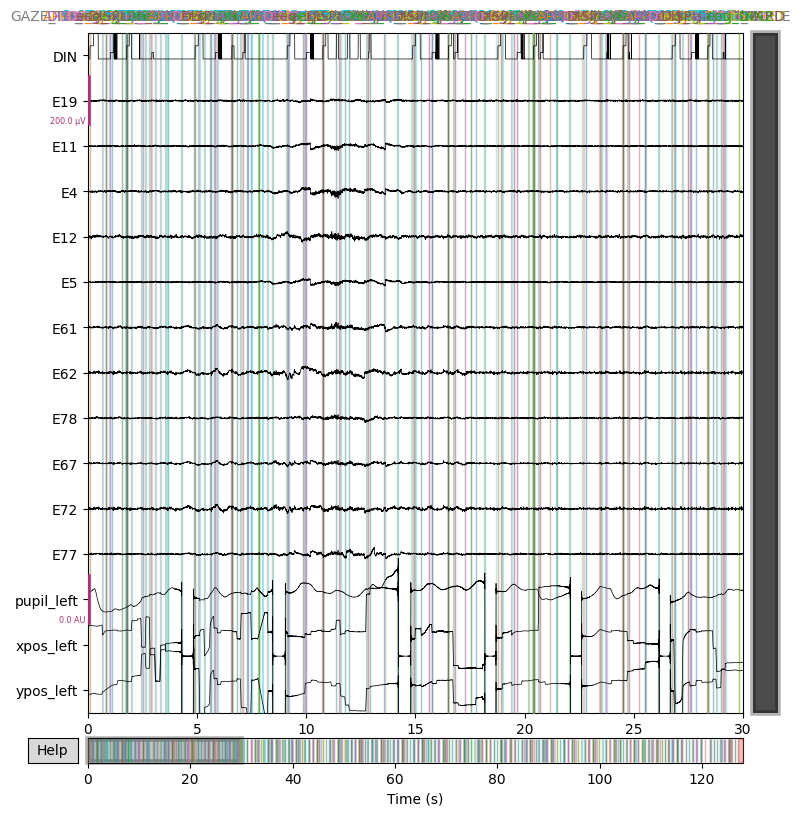

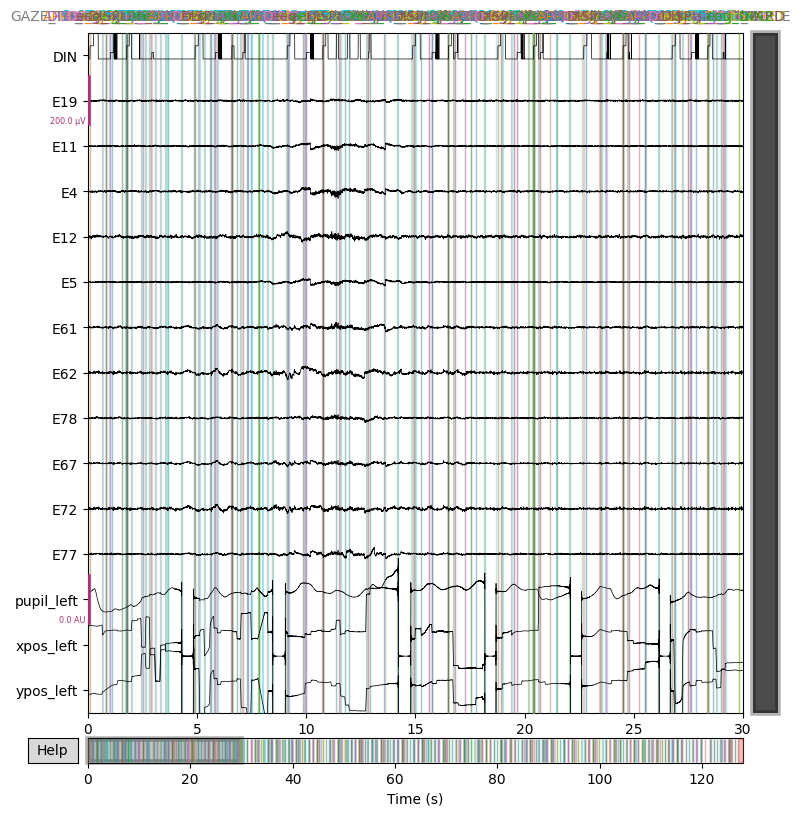

In [6]:
# Define a few channel groups of interest and plot the data
frontal = ["E19", "E11", "E4", "E12", "E5"]
occipital = ["E61", "E62", "E78", "E67", "E72", "E77"]
din = ["DIN"]
pupil = ["pupil_left"]
x_pos = ["xpos_left"]
y_pos = ["ypos_left"]

#scale_dict = dict(eeg=1e-4, eyegaze=30, pupil=30)
scale_dict = dict(eeg=1e-4, eyegaze=30, pupil=30)

# picks must be numeric (not string) when passed to `raw.plot(..., order=)`
picks_idx = mne.pick_channels(eeg_raw.ch_names, din + frontal + occipital + pupil + x_pos + y_pos, ordered=True)
#picks_idx = mne.pick_channels(eeg_raw.ch_names, frontal + occipital, ordered=True)
eeg_raw.plot(start=0,duration=30,order=picks_idx, scalings=scale_dict)

# Segment the data to 'sv06' and 'sv15'

In [7]:
# Get the events form the annotations
eeg_events, eeg_event_dict  = mne.events_from_annotations(eeg_raw)

## Relabel condition vars for niceness
eeg_event_dict['vs/display/search/a5/ca'] = eeg_event_dict.pop('ds5a')
eeg_event_dict['vs/display/search/a5/cc'] = eeg_event_dict.pop('ds5c')
eeg_event_dict['vs/display/search/a5/cs'] = eeg_event_dict.pop('ds5s')

eeg_event_dict['vs/display/search/a9/ca'] = eeg_event_dict.pop('ds9a')
eeg_event_dict['vs/display/search/a9/cc'] = eeg_event_dict.pop('ds9c')
eeg_event_dict['vs/display/search/a9/cs'] = eeg_event_dict.pop('ds9s')

eeg_event_dict['vs/display/search/at/cc'] = eeg_event_dict.pop('dstc')


Used Annotations descriptions: ['ACQ_SKIP', 'APPLE_FLY_IN', 'DISPLAY_BLANK', 'DISPLAY_FIXATION', 'DISPLAY_REWARD', 'DISPLAY_SEARCH', 'GAZE_TO_ATTENTION_APPLE', 'GAZE_TO_TARGET', 'STIM_d', 'TRSP', 'bgn1', 'blink', 'da5a', 'da5c', 'da5s', 'da9a', 'da9c', 'da9s', 'datc', 'db5a', 'db5c', 'db9a', 'db9c', 'db9s', 'dbtc', 'df5a', 'df5c', 'df5s', 'df9a', 'df9c', 'df9s', 'df_d', 'dftc', 'dr5a', 'dr5c', 'dr5s', 'dr9a', 'dr9c', 'dr9s', 'drtc', 'ds5a', 'ds5c', 'ds5s', 'ds9a', 'ds9c', 'ds9s', 'dstc', 'eeg_DIN2', 'eeg_DIN3', 'eeg_sync_time', 'et_DIN2', 'et_DIN4', 'et_sync_time', 'fixation', 'ga5a', 'ga5c', 'ga5s', 'ga9c', 'ga9s', 'gatc', 'gt5a', 'gt5c', 'gt5s', 'gt9a', 'gt9c', 'gt9s', 'gttc', 'saccade']


In [8]:
eeg_event_dict

{'ACQ_SKIP': 1,
 'APPLE_FLY_IN': 2,
 'DISPLAY_BLANK': 3,
 'DISPLAY_FIXATION': 4,
 'DISPLAY_REWARD': 5,
 'DISPLAY_SEARCH': 6,
 'GAZE_TO_ATTENTION_APPLE': 7,
 'GAZE_TO_TARGET': 8,
 'STIM_d': 9,
 'TRSP': 10,
 'bgn1': 11,
 'blink': 12,
 'da5a': 13,
 'da5c': 14,
 'da5s': 15,
 'da9a': 16,
 'da9c': 17,
 'da9s': 18,
 'datc': 19,
 'db5a': 20,
 'db5c': 21,
 'db9a': 22,
 'db9c': 23,
 'db9s': 24,
 'dbtc': 25,
 'df_d': 32,
 'dr5a': 34,
 'dr5c': 35,
 'dr5s': 36,
 'dr9a': 37,
 'dr9c': 38,
 'dr9s': 39,
 'drtc': 40,
 'ds5a': 41,
 'ds5c': 42,
 'ds5s': 43,
 'ds9a': 44,
 'ds9c': 45,
 'ds9s': 46,
 'dstc': 47,
 'eeg_DIN2': 48,
 'eeg_DIN3': 49,
 'eeg_sync_time': 50,
 'et_DIN2': 51,
 'et_DIN4': 52,
 'et_sync_time': 53,
 'fixation': 54,
 'ga5a': 55,
 'ga5c': 56,
 'ga5s': 57,
 'ga9c': 58,
 'ga9s': 59,
 'gatc': 60,
 'gt5a': 61,
 'gt5c': 62,
 'gt5s': 63,
 'gt9a': 64,
 'gt9c': 65,
 'gt9s': 66,
 'gttc': 67,
 'saccade': 68,
 'vs/display/search/a5/ca': 26,
 'vs/display/search/a5/cc': 27,
 'vs/display/search/a5/cs': 2

In [9]:
#reject_criteria = {'eeg': 400e-6}

In [10]:
#epoch_eeg_event_dict = {key: value for key, value in eeg_event_dict.items() if key.startswith(('d', 'g','v'))}

In [11]:
#epochs = mne.Epochs(eeg_raw, eeg_events, event_id=epoch_eeg_event_dict, tmin=-1, tmax=1.0, on_missing='warn', event_repeated='drop')
#epochs

In [12]:
#epochs[['search/a5','search/a9','search/at']]

In [13]:
#create a new dictionary keeping only keys that start with 'd' or 'g' ('display' and 'gaze' onset events)
epoch_eeg_event_dict = {key: value for key, value in eeg_event_dict.items() if key.startswith(('d', 'g', 'v'))}
#print the filtered dictionary
print(epoch_eeg_event_dict)

#epoch to the filtered dictionary .. select specific conditions at a later stage..
epochs = mne.Epochs(eeg_raw, eeg_events, event_id=epoch_eeg_event_dict, tmin=-1, tmax=1.0, on_missing='warn', event_repeated='drop')
#epochs = epochs[['dtbc', 'dtoc', 'dtgc']]
display(epochs)

##apply autoreject to the epochs..
#ar = AutoReject()
#epochs.load_data()
#epochs_clean = ar.fit_transform(epochs)

#save the cleaned epochs...
epochs.save(project_path + pylossless_path + sync_loss_path + segment_path + 'epoch_fif_files/VS/' + bids_path.basename + '_epo.fif', overwrite=True)

{'da5a': 13, 'da5c': 14, 'da5s': 15, 'da9a': 16, 'da9c': 17, 'da9s': 18, 'datc': 19, 'db5a': 20, 'db5c': 21, 'db9a': 22, 'db9c': 23, 'db9s': 24, 'dbtc': 25, 'df_d': 32, 'dr5a': 34, 'dr5c': 35, 'dr5s': 36, 'dr9a': 37, 'dr9c': 38, 'dr9s': 39, 'drtc': 40, 'ds5a': 41, 'ds5c': 42, 'ds5s': 43, 'ds9a': 44, 'ds9c': 45, 'ds9s': 46, 'dstc': 47, 'ga5a': 55, 'ga5c': 56, 'ga5s': 57, 'ga9c': 58, 'ga9s': 59, 'gatc': 60, 'gt5a': 61, 'gt5c': 62, 'gt5s': 63, 'gt9a': 64, 'gt9c': 65, 'gt9s': 66, 'gttc': 67, 'vs/display/search/a5/ca': 26, 'vs/display/search/a5/cc': 27, 'vs/display/search/a5/cs': 28, 'vs/display/search/a9/ca': 29, 'vs/display/search/a9/cc': 30, 'vs/display/search/a9/cs': 31, 'vs/display/search/at/cc': 33}
Not setting metadata
235 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated


<Epochs | 235 events (good & bad), -1 – 1 s (baseline -1 – 0 s), ~154 kB, data not loaded,
 'da5a': 2
 'da5c': 6
 'da5s': 2
 'da9a': 2
 'da9c': 6
 'da9s': 2
 'datc': 10
 'db5a': 2
 'db5c': 6
 'db9a': 2
 and 38 more events ...>

Overwriting existing file.
Loading data for 235 events and 2001 original time points ...
3 bad epochs dropped
Loading data for 1 events and 2001 original time points ...
Overwriting existing file.
Loading data for 232 events and 2001 original time points ...


In [14]:
#required_conditions = {'dtbc', 'dtoc', 'dtgc'}
#available_conditions = set(epochs.event_id.keys())
#if required_conditions.issubset(available_conditions):
#    print("All required conditions are present.")
#else:
#    print("Missing conditions:", required_conditions - available_conditions)

In [15]:
# peak... at the EEG channel types
channel_types = epochs.get_channel_types()
print("EEG Channel Types:", channel_types)
print("EEG Channel Names:", epochs.info['ch_names'])

EEG Channel Types: ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'misc', 'misc', 'misc', 'stim', 'misc', 'misc', 'misc']
EEG Channel Names: ['

In [16]:
evokeds = {'s5': epochs['search/a5'].average(picks=['eeg','misc']), 's9': epochs['search/a9'].average(picks=['eeg','misc']), 's13': epochs['search/at'].average(picks=['eeg','misc'])}
mne.write_evokeds(project_path + pylossless_path + sync_loss_path + segment_path + 'erp_fif_files/GO/' + bids_path.basename + '_erp.fif',list(evokeds.values()), overwrite=True)

Overwriting existing file.


# Plot ERP envelopes and topographies

In [17]:
conditions = ['search/a5','search/a9','search/at']
#conditions = ['dtgc','dtbc','dtoc']
roi = ['E83']
eye = ['pupil_left']
decim = 2
freqs = np.arange(2, 50, 2)
n_cycles = freqs / 2

epochs = epochs[conditions]
epochs.apply_baseline((-.2, 0))


# Get the original epochs data
data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)

# Get the data for the 'xpos_left' channel
x_channel_index = epochs.ch_names.index('xpos_left')
x_data = epochs.get_data(picks=['xpos_left'])
x_baseline_mean = np.mean(x_data[:, :, 800:1000], axis=2, keepdims=True)  # Shape: (n_epochs, 1)
#x_data_adjusted = np.abs(data - baseline_means)
x_data_adjusted = x_data - x_baseline_mean

# Get the data for the 'xpos_left' channel
y_channel_index = epochs.ch_names.index('ypos_left')
y_data = epochs.get_data(picks=['ypos_left'])  # Shape: (n_epochs, 2, n_times)
#y_data = epochs.get_data()[:, y_channel_index, :]
print ('y_data shape: ', y_data.shape)
y_baseline_mean = np.mean(y_data[:, :, 800:1000], axis=2, keepdims=True)  # Shape: (n_epochs, 1)
#x_data_adjusted = np.abs(data - baseline_means)
y_data_adjusted = y_data - y_baseline_mean
print ('y_data_adjusted shape: ', y_data_adjusted.shape)

#absolute distance from baseline....
origin_distance = np.sqrt(x_data_adjusted**2 + y_data_adjusted**2)
print ('origin distance shape: ', origin_distance.shape)
#first derivative of distance from origin..
velocity = np.diff(origin_distance, axis=-1)
velocity = np.pad(velocity, ((0, 0), (0, 0), (0, 1)), mode='constant', constant_values=0)

#cumulative sum of velocity...
total_travel = np.cumsum(velocity, axis=1)




if np.any(np.isnan(x_baseline_mean)):
    print("The array contains NaN values.")
else:
    print("The array does not contain any NaN values.")


#insert the new signals into the data array.. 
ch_id = epochs.ch_names.index('distance')
data[:, ch_id, :] = origin_distance.squeeze(1)
ch_id = epochs.ch_names.index('x_head')
data[:, ch_id, :] = velocity.squeeze(1)
ch_id = epochs.ch_names.index('y_head')
data[:, ch_id, :] = total_travel.squeeze(1)

# Create a new Epochs object with modified data but original info
new_epochs = mne.EpochsArray(data, info=epochs.info, events=epochs.events, event_id=epochs.event_id, tmin=epochs.tmin)

#rename the channels...
# Define the mapping for renaming channels.. and rename the channel
rename_mapping = {'distance': 'origin_dist'}
new_epochs.rename_channels(rename_mapping)
rename_mapping = {'x_head': 'velocity'}
new_epochs.rename_channels(rename_mapping)
rename_mapping = {'y_head': 'total_travel'}
new_epochs.rename_channels(rename_mapping)


epochs = new_epochs


Applying baseline correction (mode: mean)
Loading data for 30 events and 2001 original time points ...
Loading data for 30 events and 2001 original time points ...
Loading data for 30 events and 2001 original time points ...
y_data shape:  (30, 1, 2001)
y_data_adjusted shape:  (30, 1, 2001)
origin distance shape:  (30, 1, 2001)
The array does not contain any NaN values.
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated


In [18]:
evokeds = {'s5': epochs['search/a5'].average(picks=['eeg','misc']), 's9': epochs['search/a9'].average(picks=['eeg','misc']), 's13': epochs['search/at'].average(picks=['eeg','misc'])}

No projector specified for this dataset. Please consider the method self.add_proj.


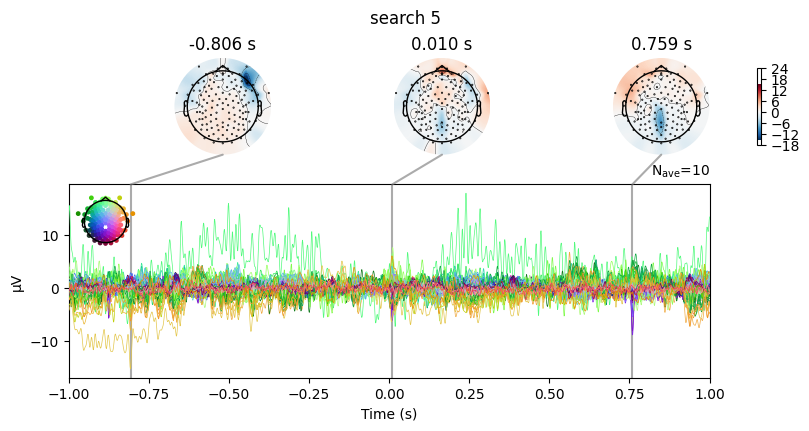

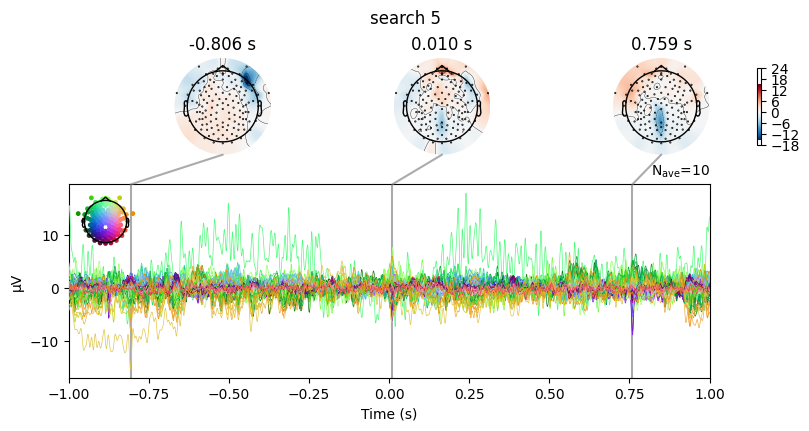

In [19]:
evokeds['s5'].plot_joint(picks=['eeg'], title='search 5')

No projector specified for this dataset. Please consider the method self.add_proj.


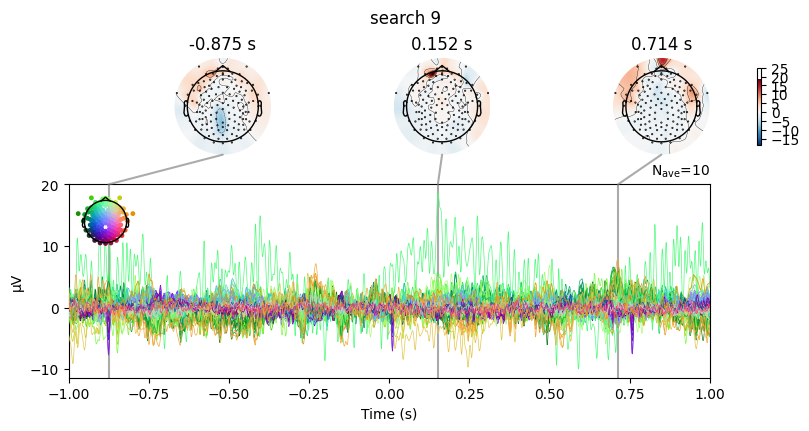

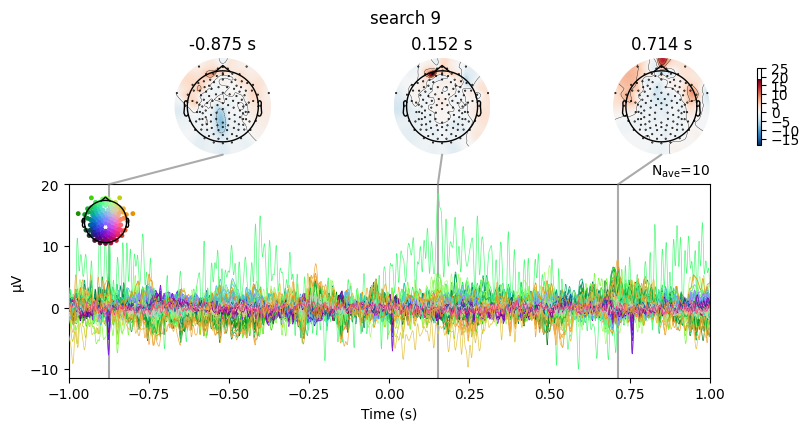

In [20]:
evokeds['s9'].plot_joint(picks=['eeg'],title='search 9')

No projector specified for this dataset. Please consider the method self.add_proj.


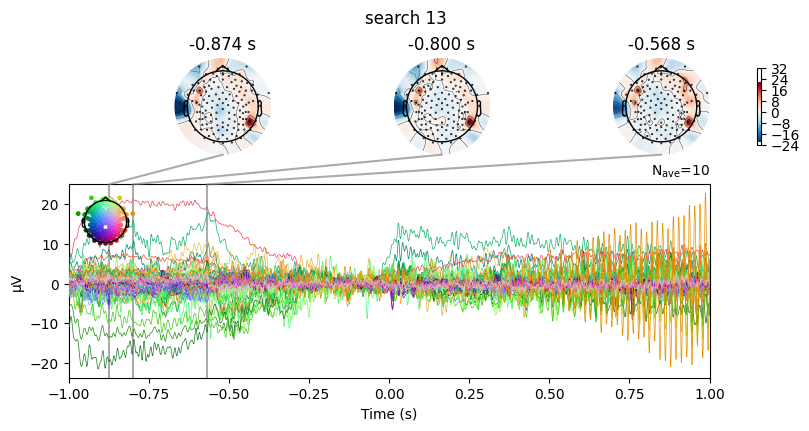

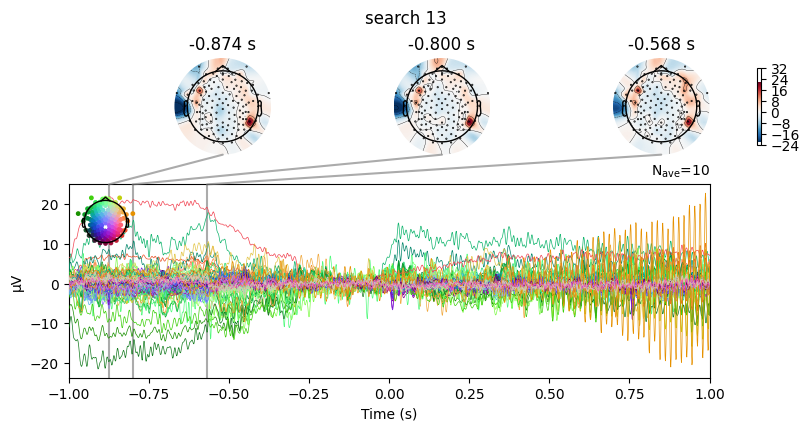

In [21]:
evokeds['s13'].plot_joint(picks=['eeg'],title='search 13')

# Plot the ERP overlay

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


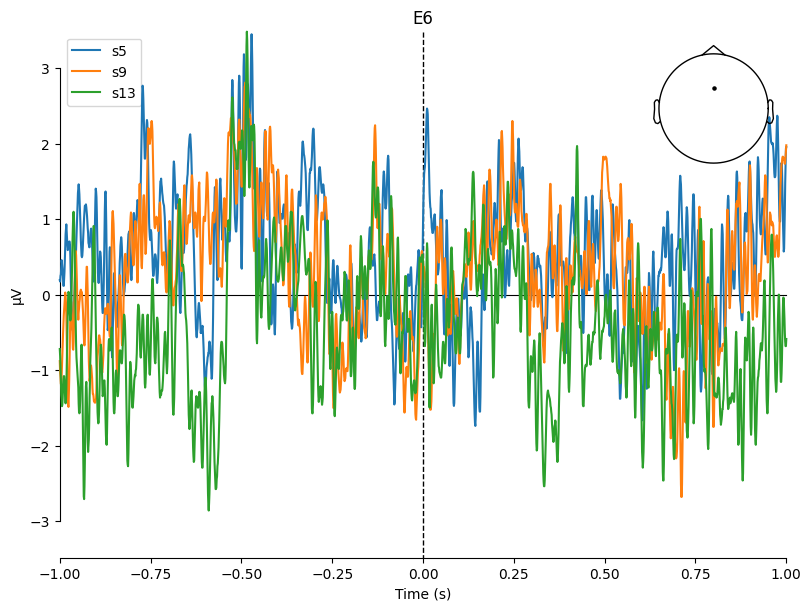

[<Figure size 800x600 with 2 Axes>]

In [22]:
# Plot ERP overlay
mne.viz.plot_compare_evokeds(evokeds, picks=['E6'], combine='mean')

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


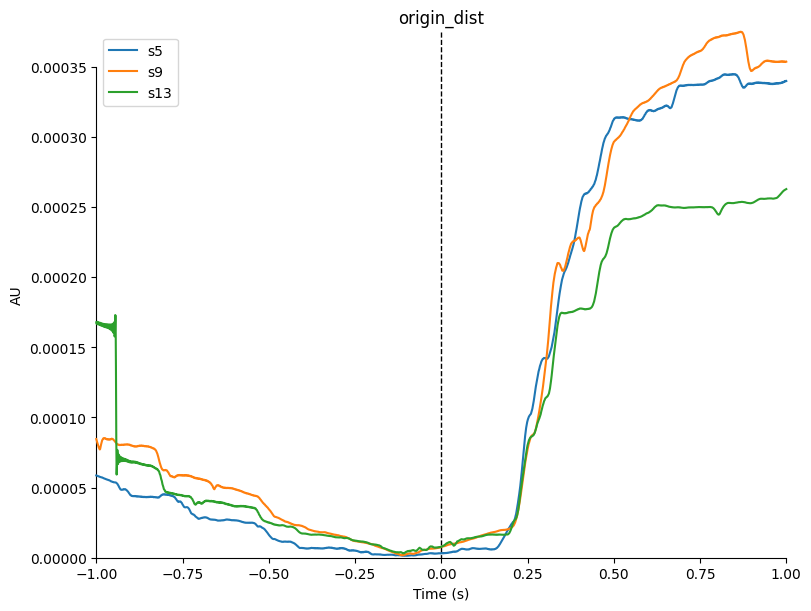

[<Figure size 800x600 with 1 Axes>]

In [27]:
# Plot ERP overlay
mne.viz.plot_compare_evokeds(evokeds, picks=['origin_dist'], combine='mean')

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


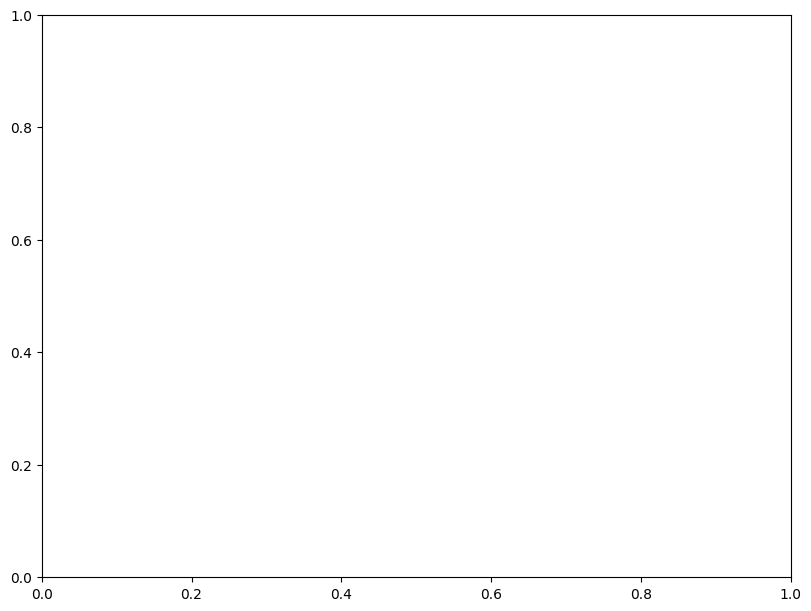

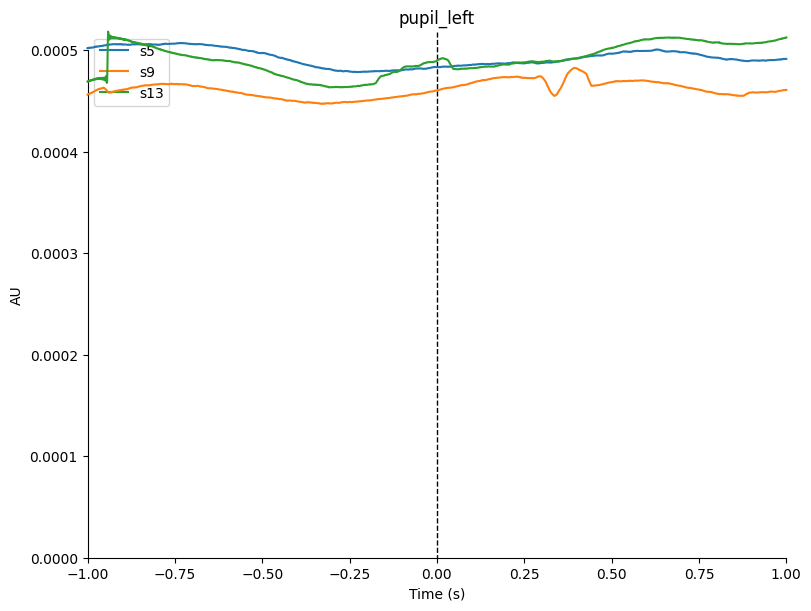

[<Figure size 800x600 with 1 Axes>]

In [25]:
# Plot ERP overlay
mne.viz.plot_compare_evokeds(evokeds, picks=['pupil_left'], combine='mean')

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


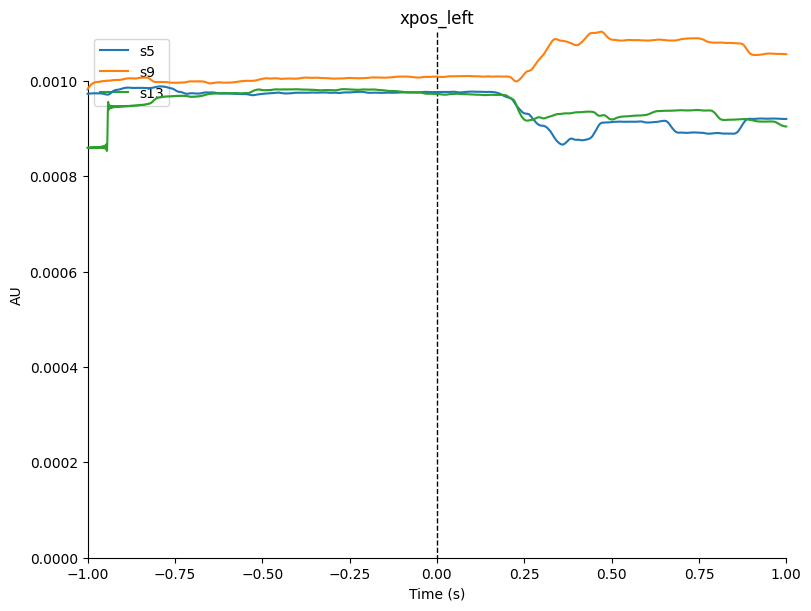

[<Figure size 800x600 with 1 Axes>]

In [26]:
# Plot ERP overlay
mne.viz.plot_compare_evokeds(evokeds, picks=['xpos_left'], combine='mean')

In [ ]:
#epochs_condition_1 = epochs['sv06']
#epochs_condition_2 = epochs['sv15']
ch_name = 'E70'

decim = 2
freqs = np.arange(3, 50, 2)  # define frequencies of interest
n_cycles = freqs / 2

#epochs_chan = epochs.pick_channels([ch_name])


In [ ]:
decim = 2
freqs = np.arange(2, 50, 2)  # define frequencies of interest
n_cycles = freqs / 2

pow_1, itc_1 = mne.time_frequency.tfr_morlet(
    epochs['search/a5'],
    freqs,
    picks=ch_name,
    n_cycles=n_cycles,
    decim=decim,
    return_itc=True,
    average=True,
)

pow_2, itc_2 = mne.time_frequency.tfr_morlet(
    epochs['search/a9'],
    freqs,
    picks=ch_name,
    n_cycles=n_cycles,
    decim=decim,
    return_itc=True,
    average=True,
)

itc_dat_1 = itc_1.data[0, :, :]  # only 1 channel as 3D matrix
pow_dat_1 = pow_1.data[0, :, :]  # only 1 channel as 3D matrix

itc_dat_2 = itc_2.data[0, :, :]  # only 1 channel as 3D matrix
pow_dat_2 = pow_2.data[0, :, :]  # only 1 channel as 3D matrix

In [ ]:
times = 1e3 * epochs['search/a5'].times  # change unit to ms

fig1, (ax1t, ax1b) = plt.subplots(2, 1, figsize=(6, 4))
fig1.subplots_adjust(0.12, 0.08, 0.96, 0.94, 0.2, 0.43)

ax1t.imshow(
    pow_dat_1,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
)

ax1b.imshow(
    itc_dat_1,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
)

ax1t.set_ylabel("Frequency (Hz)")
ax1t.set_title(f"target gap Induced power ({ch_name})")
ax1b.set_title(f"target gap Inter Trial Coherence ({ch_name})")
ax1b.set_xlabel("Time (ms)")

plt.show()

In [ ]:
fig2, (ax2t, ax2b) = plt.subplots(2, 1, figsize=(6, 4))
fig2.subplots_adjust(0.12, 0.08, 0.96, 0.94, 0.2, 0.43)

ax2t.imshow(
    pow_dat_2,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
)

ax2b.imshow(
    itc_dat_2,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
)

ax2t.set_ylabel("Frequency (Hz)")
ax2t.set_title(f"target overlap Induced power ({ch_name})")
ax2b.set_title(f"target overlap Inter Trial Coherence ({ch_name})")
ax2b.set_xlabel("Time (ms)")

plt.show()

In [ ]:
fig3, (ax3t, ax3b) = plt.subplots(2, 1, figsize=(6, 4))
fig3.subplots_adjust(0.12, 0.08, 0.96, 0.94, 0.2, 0.43)

ax3t.imshow(
    pow_dat_2 - pow_dat_1,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
)

ax3b.imshow(
    itc_dat_2 - itc_dat_1,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
)

ax3t.set_ylabel("Frequency (Hz)")
ax3t.set_title(f"gap - overlap Induced power ({ch_name})")
ax3b.set_title(f"gap - overlap Inter Trial Coherence ({ch_name})")
ax3b.set_xlabel("Time (ms)")

plt.show()

In [ ]:
!jupyter nbconvert --output {"session_reports/" + bids_path.basename + ".html"} --TagRemovePreprocessor.remove_all_outputs_tags='{"exclude"}' --no-input --to html session_seg_vp.ipynb